In [107]:
# importing the necessary Python modules to model the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from rdkit.Chem import rdFingerprintGenerator

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score

In [89]:
# Importing the dataset from a csv file to a dataframe using pandas
filepath = r'C:\Users\User\Downloads\solubility.csv'
dataset = pd.read_csv(filepath)

dataset.head()

,Compound ID,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [90]:
# Exploring the data

dataset.info()
dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Compound ID                                1128 non-null   object 
 1   Minimum Degree                             1128 non-null   int64  
 2   Molecular Weight                           1128 non-null   float64
 3   Number of H-Bond Donors                    1128 non-null   int64  
 4   Number of Rings                            1128 non-null   int64  
 5   Number of Rotatable Bonds                  1128 non-null   int64  
 6   Polar Surface Area                         1128 non-null   float64
 7   measured log solubility in mols per litre  1128 non-null   float64
 8   smiles                                     1128 non-null   object 
dtypes: float64(3), int64(4), object(2)
memory usage: 79.4+ KB


,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre
count,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000
mean,1.058511,203.937074,0.701241,1.390957,2.177305,34.872881,-3.050102
std,0.238560,102.738077,1.089727,1.318286,2.640974,35.383593,2.096441
min,0.000000,16.043000,0.000000,0.000000,0.000000,0.000000,-11.600000
25%,1.000000,121.183000,0.000000,0.000000,0.000000,0.000000,-4.317500
50%,1.000000,182.179000,0.000000,1.000000,1.000000,26.300000,-2.860000
75%,1.000000,270.372000,1.000000,2.000000,3.000000,55.440000,-1.600000
max,2.000000,780.949000,11.000000,8.000000,23.000000,268.680000,1.580000


In [110]:
"""
Fingerprints will be used to extract the feature information of the smiles
as to use it in modeling the data and predicting solubility. fingerprints can be
very useful in recognizing patterns or properties in complex molecular arrangements.
The main goal of this analysis is to determine the impact of the smiles, and the other features
in predicting solubility of the chemical compounds in our data and to predict the solubility.

Fingerprint feature extraction will use high-demensional features representation, thus improving
the model's ability to patterns and properties between the different chemical compounds.
This will significantly improve the performance of the model, especially when the relationship
between solubility and the features is non-linear.

Molecular Descriptors were also used in this data analysis. The descriptors used are molecular
weight, number of h-Bonds,number of rings, polar surface area andthe number of ratatable bonds.
These descriptors will provide information that will be useful in understanding basic properties
of solubility. Descriptors will provide improved perfomance ofthe model if the descriptor features
have a linear relationship with solubility.

The combination of the descriptors and fingerprints was to allow the model to capture 
the complex relationships between the molecular structure and solubility, improve the model's
perfomamance.


"""

morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = morgan_generator.GetFingerprint(mol)
        arr = np.zeros((fp.GetNumBits(),))
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    else:
        return np.zeros((2048,))

dataset['fingerprint'] = dataset['smiles'].apply(smiles_to_fingerprint)

fingerprint_dataset = pd.DataFrame(dataset['fingerprint'].tolist(),index = dataset.index)

features = dataset[['Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Polar Surface Area', 'Number of Rotatable Bonds']]

combined_dataset =pd.concat([features, fingerprint_dataset], axis=1)
print('process done')

process done


In [94]:
"""
Data Preprocessing:
The features from the fingerprint and descriptor were combined and used as the features for the model.
Columns were converted to numeric values to ensure dataset consistency.
Before being seperated for training the features were scaled sung the standard scaler
to ensure that the model converges faster and that all the features contribute equally to the model,
preventing other features from dominating.this improves model perfomance.
"""

X = combined_dataset
y = dataset['measured log solubility in mols per litre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)
scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
print('process done')

process done


In [109]:
"""
The randomForestmodel was used to model the dataset,
K-Fold cross validation was performed to evaluate the model's performance on
unseen data ans ensures that the model does not overfit the data.These results
are presented by the cross validationmean squared error.

The Mean Squared Error (MSE) assesses the accuracy of predictions, where lower values 
indicate that 

R-sqaured score represents the proportion of variance explained by the model. 
A higher variance means better modelperfomance?

The Explaine variance score complements the R-squared score, it shows howmuch variance
is being captured by the model. 

"""

rf = RandomForestRegressor(n_estimators=100, random_state = 42)

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(rf, scaled_X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

# Train Random Forest model
rf.fit(scaled_X_train, y_train)

y_pred = rf.predict(scaled_X_test)

# Evaluate the model using r-squared MSE, and explained variance score

explained_variance = explained_variance_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Cross-Validation Mean Squared Error: ", -np.mean(cv_results))
print("Model Mean Squared Error: ", mse)
print("Model R^2 Score: ", r2)
print("Explained Variance Score: ", explained_variance)
print('process done')



Cross-Validation Mean Squared Error:  0.7097240382188217
Model Mean Squared Error:  0.6772515749756016
Model R^2 Score:  0.8567210216202132
Explained Variance Score:  0.8567259405379252
process done


In [106]:
"""
Feature importance plot analyzes the importance of fingerprints and descriptors
to understand how much they contribute to the model's performance.
"""

# Feature Importance Plot for Top 10 Features
plt.figure(figsize=(108, 100))
importances = rf.feature_importances_
features_names = list(features.columns) + [f'FP_{i}' for i in range(fingerprint_dataset.shape[1])]
indices = np.argsort(importances)[::-1]

top_n = 10
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_features_names = np.array(features_names)[top_indices]

plt.title('Top 10 Feature Importances', fontsize=80)
plt.bar(range(top_n), top_importances, align='center')
plt.xticks(range(top_n), top_features_names, rotation=90, fontsize=50)
plt.xlim([-1, top_n])
plt.tight_layout(pad=2)
plt.show()


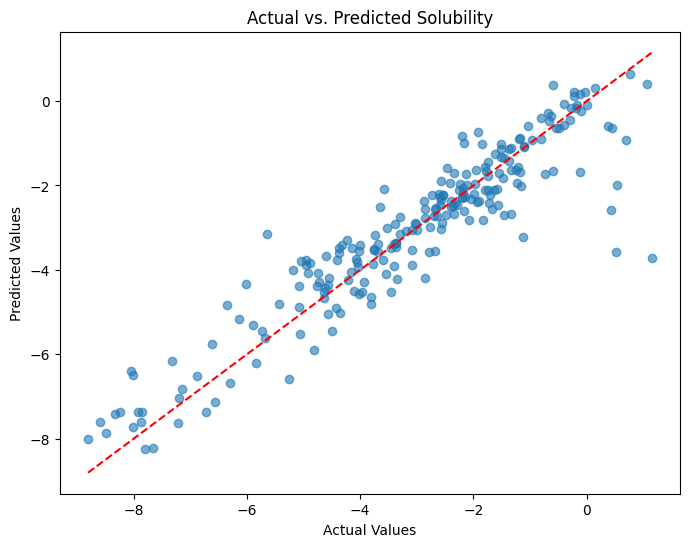

In [73]:
"""
The actual vs Predicted solubility plot is a scatter plot used to visually represent the predictions of the 
model. It includes a reference line which represents the ideal case where the predicted values match
the actual values. 
If the points are closely aligned along the reference line, it indicates that the model’s
predictions are close to the actual values, showing good performance.
If there is a lot of dispersion or deviation from the reference line suggests that the model’s
predictions are not very accurate.

This plot also represents the distribution of the model's predictions.
"""

# Actual vs. Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Solubility')
plt.show()

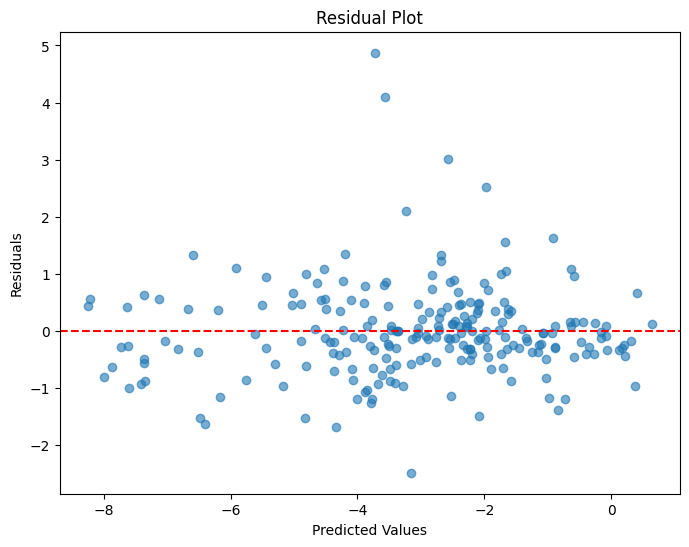

In [74]:
"""
The Residual plot is a scatter plot that maps the residual values against the
predicted values. The plot includes a horizontal reference line at 0 which represents
an ideal case where residuals are zero meaning accurate prediction.

This plot helps in visualizing whether the residuals are centered
around zero, which is an indication of unbiased predictions.
If the residuals deviate from the 
"""

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [ ]:
"""
Discussion and analysis of results:

The Cross validation Mean Squre error, has a value of 0.7097. This is a relatively
low value which suggests that the model is making good predictions on the training data.
The Cross validation Mean Squre error measures the average squared difference between 
predicted and actual values during the training phase, so the lower the value the better 
the model performs.

The Mean Squared Error for the model(MSE), which is calculated from the training set,
has a value of 0.6773. This is lower than the cross-validation value,which is means that
the model performed a bit better on the test set than on the average cross-validation folds
and generalizes well to unseen data.

The explained variance score is similar to the R² score and measures the proportion of
variance in the dependent variable that is predictable from the independent variables.
Our model achieved an explained variance score of 0.8567 which confirms the result
from the R² score.
The score indicates that 85.67% of the variance in the target variable is
explained by the model.
This score provides an understanding of the model’s capability to capture the variance
of the target variable.

The R-Squared score of the model, is a coeffiecient of determination. It indicates
how well the modelexplians the variance in the target variable. The value from our
dataset model is 0.8567,this vaule is high, meaning that the model explains 85.67 
percent of the variance in the target variable and the model has great predictive abilities.

In the performance feature plot, molecular weight has the highest performance,
indicating that it plays a very important role in predicting the solubility 
in our dataset.
The Polar surface area was the second most important feature in the predicting
solubility for our dataset. This suggests that solubility might have a close
relationship with molecular weight and polarity, and that these two features
are strong predictors of solubility. his could imply that solubility is more
influenced by these general physical properties rather than specific molecular
substructures captured by fingerprints.

The molecular fingerprints, which represented the structural features(smiles) of 
the molecule were the least important features. This suggests that these fingerprints 
may not be showing the properties that affect solubility or patterns of solubility
of the molecules or that molecular structures are less relevant in determining the
solubility of molecules.. The low importance of fingerprints suggests that the specific
method or choice of fingerprints may not be optimal for this problem. 

In the actual vs predicted solubility plot, the points are closely aligned along
the reference line, forming a tight clustering around this line
indicates good predictive performance.
This means that the model's predictions are so close to the actual values,
which shows that the model has good performance.

In the Residual plot, the residuals are randomly scattered around the reference
line with no apparent pattern, this means that the model has randomly distributed
and is correctly captures the relationships between the features and the target variable.
There was less bias in the predictions, hence there was no systematic overestimation or 
underestimation.


Potential areas of improvement:
- Hyperparameter tuning for improved performance.
- Dimensionality reduction: the fingers produced many columns which
were slowing down the execution of the program on my computer. This could
be the result of the high computational power needed because of the complexity
of the fingerprints. I should have considered reducing the dimensions of the feature
using dimensionality reduction techniques.
- Consider using different types of fingerprints or increasing the resolution to capture
more detailed structural information that is relevant to solubility.
"""